In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
os.environ["KERAS_BACKEND"] = "tensorflow"


from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

In [14]:
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

In [15]:
classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [18]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
val_datagen.fit(x_val)

In [19]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
res50_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3), # Changed input shape to (224, 224, 3)
)

res50_model.summary()
res50_model.trainable = False

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
for layers in res50_model.layers:
    layers.trainable = False



In [22]:
# Define your model
model = tf.keras.Sequential() # Resize layer
model.add(tf.keras.layers.Resizing(224, 224, interpolation="bilinear"))
model.add(res50_model)  # Add resnet50
model.add(Flatten())  # Flatten the output and add dense layers
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(512, activation='tanh'))
##Note, just having Softmax seems to do it
model.add(Dense(100, activation='softmax'))  # Final layer for 100 classes

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer= optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [24]:
history = model.fit(
    # train_datagen.flow(x_train, y_train, batch_size = 64),
    # validation_data = val_datagen.flow(x_val,y_val, batch_size = 64),
    train_datagen.flow(x_train, y_train),
    validation_data = val_datagen.flow(x_val,y_val),
    epochs = 100,
    verbose = 1,
    # callbacks = [learning_rate_reduction]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 88ms/step - accuracy: 0.3944 - loss: 2.5119 - val_accuracy: 0.6055 - val_loss: 1.3847
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.5500 - loss: 1.6062 - val_accuracy: 0.6216 - val_loss: 1.3208
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.5754 - loss: 1.4891 - val_accuracy: 0.6295 - val_loss: 1.2838
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.5851 - loss: 1.4463 - val_accuracy: 0.6374 - val_loss: 1.2604
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.5991 - loss: 1.4000 - val_accuracy: 0.6352 - val_loss: 1.2727
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.6038 - loss: 1.3809 - val_accuracy: 0.6442 - val_loss: 1.2482
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.6065 - loss: 1.3844 - val_accuracy: 0.6392 - val_loss: 1.2595
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - ac

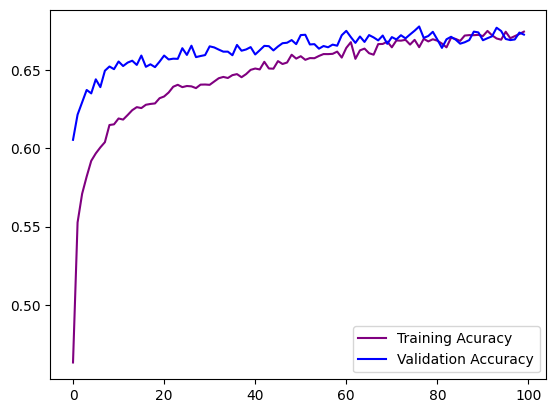

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

model.save('./100epoch512dense_2.keras')

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

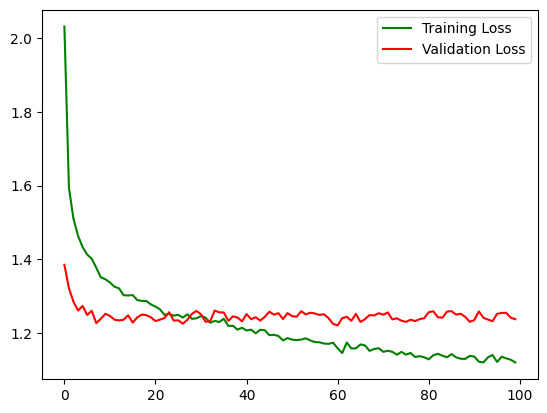

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

In [27]:
# Preprocess the input
x_test = tf.keras.applications.resnet50.preprocess_input(X_test)

# Get predictions
y_pred_prob = model.predict(x_test)  # Get the probability predictions
y_pred = y_pred_prob.argmax(axis=-1)  # Get the class predictions

# Display the first 10 predictions
y_pred[:10]


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step


array([68, 33, 55, 51, 71, 45, 42, 75, 71,  0])

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('Testing Accuarcy : ', accuracy_score(Y_test, y_pred))

Testing Accuarcy :  0.6647


Overall AUC-ROC score: 0.99018051010101
Mean Average Precision (MAP): 0.735879213461131
Precision (mean across classes): 0.735879213461131


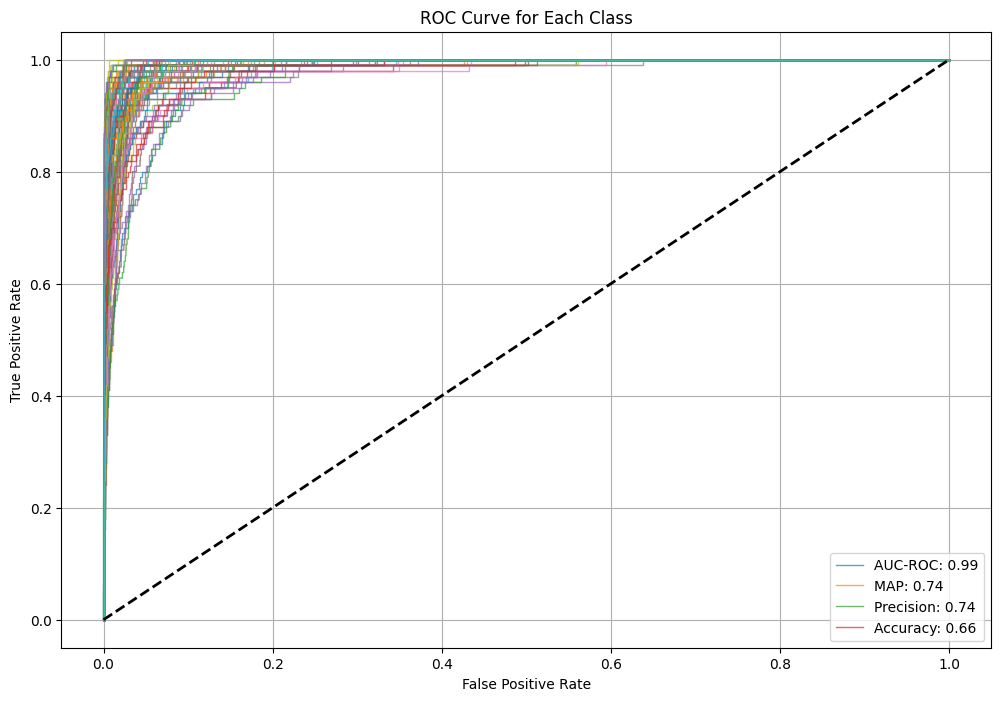

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class AUC computation
n_classes = y_pred_prob.shape[1]  # Automatically set to the number of output classes
Y_test_binarized = label_binarize(Y_test, classes=np.arange(n_classes))

# Compute the overall AUC-ROC score using one-vs-rest (OvR)
auc_roc = roc_auc_score(Y_test_binarized, y_pred_prob, multi_class='ovr')
print("Overall AUC-ROC score:", auc_roc)

# Compute Mean Average Precision (MAP)
map_score = average_precision_score(Y_test_binarized, y_pred_prob, average='macro')
print("Mean Average Precision (MAP):", map_score)

# Compute Precision score for each class (one-vs-rest) and average
precision_per_class = average_precision_score(Y_test_binarized, y_pred_prob, average=None)
precision = np.mean(precision_per_class)
print("Precision (mean across classes):", precision)

# Plot the ROC curve for each class without adding class labels on the plot
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(Y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=1, alpha=0.7)  # Reduced opacity for clarity

# Additional details for the plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')

# Add custom legend with metrics
plt.legend([f"AUC-ROC: {auc_roc:.2f}",
            f"MAP: {map_score:.2f}",
            f"Precision: {precision:.2f}",
            f"Accuracy: {accuracy_score(Y_test, y_pred):.2f}"],
           loc='lower right')

plt.grid(True)  # Add grid lines for better readability
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step


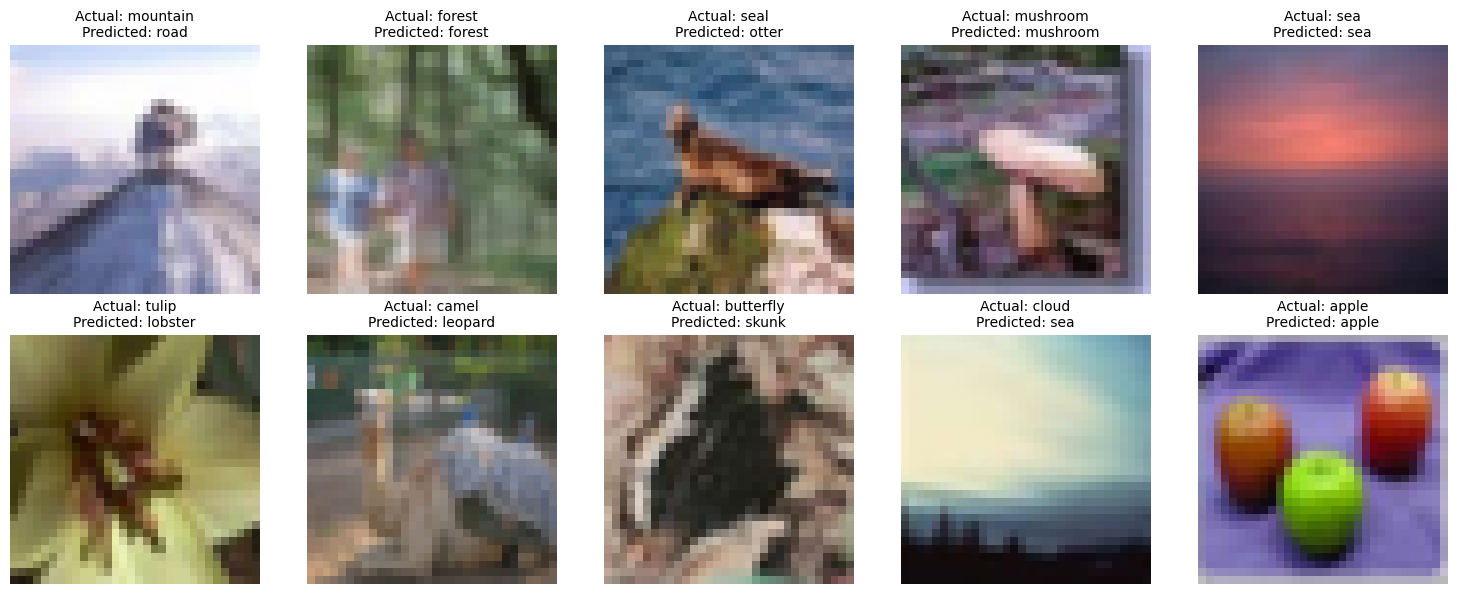

In [30]:

# Ensure the model has been used to make predictions on x_test
y_pred_prob = model.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)  # Get the class predictions

# Define the number of images to display
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Display in a 2x5 grid

for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(X_test[i].astype("uint8"))  # Ensure the image is uint8 for correct display
    
    # Set the title with actual and predicted labels
    actual_label = classes[Y_test[i][0]]
    predicted_label = classes[y_pred[i]]
    ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    
    # Remove the axes for a cleaner look
    ax.axis('off')

plt.tight_layout()
plt.show()
